### Application of functions looped over a profile
This is needed in order to: 
- [ ] associate measured points with locations within a profile (with the option to look a little bit upstream and downstream)
- [ ] apply the Lacey functions on each profile
- [ ] apply least squares fitting functions on each profile
- [ ] optimize single parameters over all profiles eventually

Here we focus on one single profile application first.

In [1]:
import orprofile
import geopandas as gpd
import os
import xugrid as xu
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fn_splines = "../examples/data/splines.geojson"
fn_points = "../examples/data/bamboi_survey.geojson"
splines = gpd.read_file(fn_splines)

mesh = orprofile.api.mesh.Mesh(splines, n=10, m=10, points=fn_points)
mesh


n: 10
m: 10
crs: EPSG:32630
points head: 0    POINT Z (606710.784 901563.864 116.184)
1    POINT Z (606711.532 901564.532 116.064)
2    POINT Z (606711.684 901564.399 116.204)
3    POINT Z (606711.825 901564.825 116.054)
4    POINT Z (606711.600 901563.848 116.104)
Name: geometry, dtype: geometry

In [3]:
mesh.mesh2d

<xarray.Dataset>
Dimensions:            (mesh2d_nFaces: 100, mesh2d_nMax_face_nodes: 4,
                        mesh2d_nEdges: 220, two: 2, mesh2d_nNodes: 121)
Coordinates:
    mesh2d_node_x      (mesh2d_nNodes) float64 6.068e+05 6.068e+05 ... 6.066e+05
    mesh2d_node_y      (mesh2d_nNodes) float64 9.016e+05 9.016e+05 ... 9.014e+05
Dimensions without coordinates: mesh2d_nFaces, mesh2d_nMax_face_nodes,
                                mesh2d_nEdges, two, mesh2d_nNodes
Data variables:
    mesh2d             int64 0
    mesh2d_face_nodes  (mesh2d_nFaces, mesh2d_nMax_face_nodes) int64 0 ... 109
    mesh2d_edge_nodes  (mesh2d_nEdges, two) int64 0 1 0 11 1 ... 118 119 119 120
Attributes:
    Conventions:  CF-1.9 UGRID-1.0

### organizing rows and columns into a XUGridDataSet

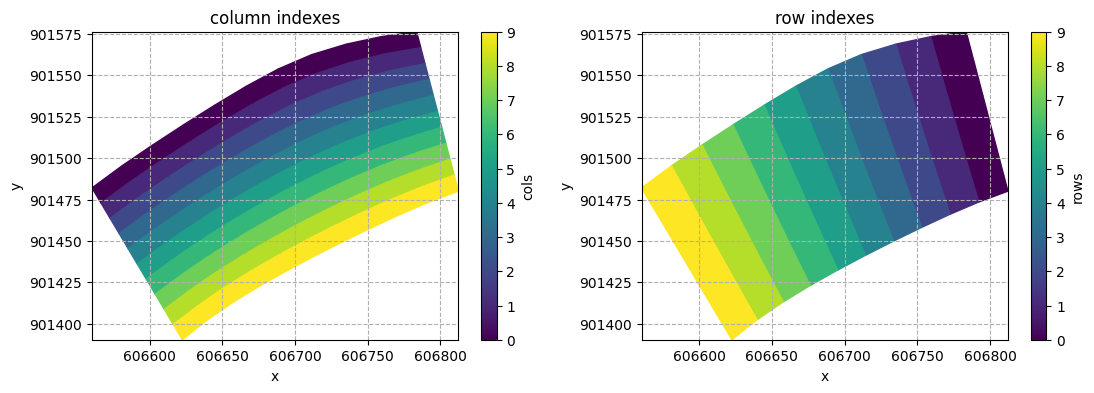

In [4]:
# make a columns and row coordinate for each node
columns = np.repeat([np.arange(mesh.n)], mesh.m, axis=0).flatten()
rows = np.repeat(np.arange(mesh.m), mesh.n)

# prepare UgridDataArrays, using the grid
da_rows = xu.UgridDataArray(
    xr.DataArray(
        data=rows,
        dims=[mesh.mesh2d.face_dimension]
    ),
    grid=mesh.mesh2d,
)
da_cols = xu.UgridDataArray(
    xr.DataArray(
        data=columns,
        dims=[mesh.mesh2d.face_dimension]
    ),
    grid=mesh.mesh2d,
)

# combine everything into a UgridDataSet
ds = xu.UgridDataset(grids=mesh.mesh2d)
ds.coords["rows"] = da_rows
ds.coords["cols"] = da_cols
# ds.coords["node_x"] = (mesh.mesh2d.face_dimension, mesh.mesh2d.node_x)
# ds.coords["node_y"] = (mesh.mesh2d.face_dimension, mesh.mesh2d.node_y)
ds["rows"] = da_rows
ds["cols"] = da_cols

# make a fancy plot
f, axs = plt.subplots(ncols=2, figsize=(13, 4))
ds.cols.ugrid.plot(ax=axs[0])
ds.rows.ugrid.plot(ax=axs[1])
axs[0].set_title("column indexes")
axs[1].set_title("row indexes")
axs[0].grid(linestyle="--")
axs[1].grid(linestyle="--")


In [5]:
ds_g = ds.groupby("rows")
ds_1 = list(ds_g)[0][1]
grid_sel = mesh.mesh2d.isel(mesh2d_nFaces=ds_1.mesh2d_nFaces.values)
ds_1_ug = xu.UgridDataset(ds_1, grids=grid_sel)
ds_1_ug.ugrid.grid.node_x
# ds_1_ug.ugrid.set_node_coords



array([606783.62814976, 606786.50171315, 606789.37529201, 606792.24885541,
       606795.12250053, 606797.99599743, 606800.86960246, 606803.74314013,
       606806.61674366, 606809.49034914, 606812.36388718, 606759.29522774,
       606762.5485705 , 606765.82848115, 606769.12231188, 606772.42250176,
       606775.72489674, 606779.02899479, 606782.33643127, 606785.65161778,
       606788.98083225, 606792.33237721])

In [6]:
list(ds_g)[1][1]

<xarray.Dataset>
Dimensions:        (mesh2d_nFaces: 10)
Coordinates:
    rows           (mesh2d_nFaces) int64 1 1 1 1 1 1 1 1 1 1
    cols           (mesh2d_nFaces) int64 0 1 2 3 4 5 6 7 8 9
  * mesh2d_nFaces  (mesh2d_nFaces) int64 10 11 12 13 14 15 16 17 18 19
Data variables:
    *empty*

### develop a mapping function that can be applied per row or column
We need a special mapping function because xugrid cannot yet handle groupby / map combinations without
destroying the ugrid property. Here we develop functions that add the grid for each group internally until
xugrid is updated.

In [7]:
# general mapping function, which must become an internal method in mesh
def map_func(row, f, ugrid, name="new", **kwargs):
    grid_sel = ugrid.isel(mesh2d_nFaces=row.mesh2d_nFaces.values)
    row_ug = xu.UgridDataset(row, grids=grid_sel)
    # now apply the function
    result = f(row_ug, **kwargs)
    result.name = name
    return result

# specific function that computes something. This can be made by the user and applied
def get_dist(row):
    # get the centroid coordinates of each face
    x = row.ugrid.to_geodataframe().centroid.x
    y = row.ugrid.to_geodataframe().centroid.y
    # compute the difference in distance per grid cell from one bank to the other
    ds = (np.diff(x)**2 + np.diff(y)**2)**0.5
    # distance from bank
    s = np.cumsum(np.pad(ds, (1, 0), "constant"))
    # use the "cols" variable as a template
    da = row["cols"]
    da[:] = s
    return xr.DataArray(da)




(606547.7445775287, 606824.9648066895, 901381.0722441283, 901585.5948099039)

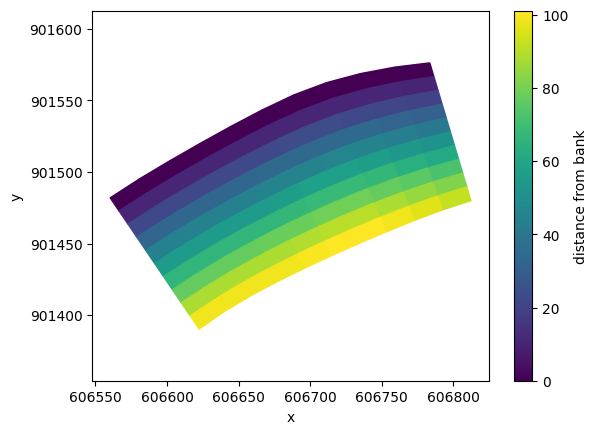

In [8]:
distance = xu.UgridDataArray(
    ds_g.map(
        map_func,
        f=get_dist,
        name="distance from bank",
        ugrid=mesh.mesh2d
    ),
    grid=mesh.mesh2d
)
ax = plt.axes()
distance.ugrid.plot(ax=ax)
ax.axis("equal")


### functionality migrated to orprofile package
Below we also test the functionality within tre orprofile package in `Mesh.api.mesh`, this should give the same results

(606547.7445775287, 606824.9648066895, 901381.0722441283, 901585.5948099039)

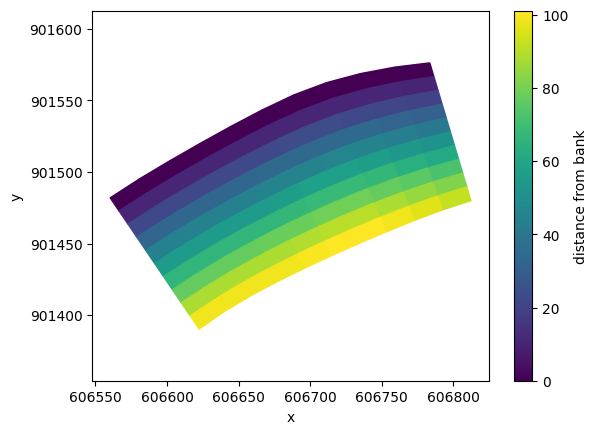

In [9]:
distance = mesh.map_rowwise(orprofile.profile.get_dist, name="distance from bank")
ax = plt.axes()
distance.ugrid.plot(ax=ax)
ax.axis("equal")
